In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from tqdm.auto import tqdm
import xgboost as xgb
from catboost import CatBoostRegressor
from pprint import pprint
from sklearn.model_selection import KFold
from sklearn.base import clone

In [2]:
df_train = pd.read_csv("regression-tabular-california-housing/train.csv", index_col=0, header=0)
df_train['RoomsPerPerson'] = df_train['AveRooms'] / df_train['AveOccup']
df_train['BedroomsPerRoom'] = df_train['AveBedrms'] / df_train['AveRooms']

bins = [0, 10, 30, np.inf]
labels = ['New', 'Mid-Age', 'Old']
df_train['AgeGroup'] = pd.cut(df_train['HouseAge'], bins=bins, labels=labels, right=False)
df_train = pd.get_dummies(df_train, columns=['AgeGroup'], drop_first=True)

CAP = df_train['MedHouseVal'].max()
FLOOR = df_train['MedHouseVal'].min()

In [3]:
train_val_split = 0.2
random_state = 42

X = df_train.drop(columns=['MedHouseVal'])
y = df_train['MedHouseVal']

normalize_cols = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'RoomsPerPerson', 'BedroomsPerRoom' ]


# normalize training data and store the mu and std
normalize_params = {col:{"mu":0.0, 'std':"0.0"} for col in normalize_cols}
for col in normalize_cols: 
    mu = X[col].mean()
    std = X[col].std(ddof=1)
    
    X[col] = (X[col] - mu)/std
    
    normalize_params[col]["mu"] = mu
    normalize_params[col]["std"] = std

X_train, X_Val, y_train, y_Val = train_test_split(X, y, test_size=train_val_split, random_state=random_state)

# XG Boost

In [4]:
def find_best_params_xgb(X, y, sample_weight, X_val, y_val, param_grid, random_state=42):
    """
    Runs grid search using XGBoost's native API for a given (X, y, weights).
    Returns the best parameters and score.
    """
    dtrain = xgb.DMatrix(X, label=y, weight=sample_weight)
    dval = xgb.DMatrix(X_val, label=y_val)

    best_params = None
    best_score = float("inf")

    total = np.prod([len(v) for v in param_grid.values()])
    with tqdm(total=total, desc="XGB Grid Search") as pbar:
        for n_estimators in param_grid['n_estimators']:
            for learning_rate in param_grid['learning_rate']:
                for max_depth in param_grid['max_depth']:
                    for subsample in param_grid['subsample']:
                        for colsample_bytree in param_grid['colsample_bytree']:

                            model = xgb.train(
                                params={
                                    'eval_metric': 'rmse',
                                    'objective': 'reg:squarederror',
                                    'eta': learning_rate,
                                    'max_depth': max_depth,
                                    'subsample': subsample,
                                    'colsample_bytree': colsample_bytree,
                                    'seed': random_state,
                                    'nthread': -1,
                                },
                                dtrain=dtrain,
                                num_boost_round=n_estimators,
                                evals=[(dval, 'eval')],
                                early_stopping_rounds=50,
                                verbose_eval=False
                            )

                            y_pred = model.predict(dval)
                            current_mse = mean_squared_error(y_val, y_pred)

                            if current_mse < best_score:
                                best_score = current_mse
                                best_params = {
                                    'n_estimators': n_estimators,
                                    'learning_rate': learning_rate,
                                    'max_depth': max_depth,
                                    'subsample': subsample,
                                    'colsample_bytree': colsample_bytree,
                                }

                            pbar.update(1)

    return best_params, best_score


In [5]:
# Specialists
specialist_configs = [
    (0, 5, 50.0,  "lxgb"),     # bottom 5%
    (5, 30, 50.0, "lmxgb"),    # low-mid
    (30, 60, 50.0,"mxgb"),     # middle
    (60, 95, 50.0,"hmxgb"),    # high-mid
    (95, 100, 50.0,"uxgb")     # top 5%
]


In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_Val, label=y_Val)

param_grid_xgb = {
    'n_estimators': [800, 900, 1200],        #   best is 900
    'learning_rate': [0.01, 0.03, 0.05],    #   best is 0.03
    'max_depth': [9,10,12],                #   best is 7
    'subsample': [ 0.8,0.9,1.0],            #   best is 0.9
    'colsample_bytree': [0.7,0.8,1.0],     #   best is 0.9
}

specialists_best_params = {}

for low, high, w, name in specialist_configs:
    lower_thr = np.percentile(y_train, low)
    upper_thr = np.percentile(y_train, high)

    sw = np.ones_like(y_train, dtype=float)
    sw[(y_train >= lower_thr) & (y_train <= upper_thr)] = w

    print(f"Tuning specialist {name} with weight {w} "
          f"on {low}-{high} percentile range...")

    best_params, best_score = find_best_params_xgb(
        X_train, y_train, sw,
        X_Val, y_Val,
        param_grid_xgb,
        random_state
    )

    specialists_best_params[name] = {
        "params": best_params,
        "score": best_score,
        "weights": sw
    }

print("Specialist params found:")
for name, data in specialists_best_params.items():
    print(name, "=>", data["params"], "MSE:", data["score"])

Tuning specialist lxgb with weight 50.0 on 0-5 percentile range...


XGB Grid Search:   0%|          | 0/243 [00:00<?, ?it/s]

Tuning specialist lmxgb with weight 50.0 on 5-30 percentile range...


XGB Grid Search:   0%|          | 0/243 [00:00<?, ?it/s]

Tuning specialist mxgb with weight 50.0 on 30-60 percentile range...


XGB Grid Search:   0%|          | 0/243 [00:00<?, ?it/s]

Tuning specialist hmxgb with weight 50.0 on 60-95 percentile range...


XGB Grid Search:   0%|          | 0/243 [00:00<?, ?it/s]

Tuning specialist uxgb with weight 50.0 on 95-100 percentile range...


XGB Grid Search:   0%|          | 0/243 [00:00<?, ?it/s]

Specialist params found:
lxgb => {'n_estimators': 900, 'learning_rate': 0.01, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8} MSE: 0.3567570265328638
lmxgb => {'n_estimators': 900, 'learning_rate': 0.03, 'max_depth': 10, 'subsample': 0.9, 'colsample_bytree': 0.8} MSE: 0.3832441909153804
mxgb => {'n_estimators': 900, 'learning_rate': 0.05, 'max_depth': 10, 'subsample': 1.0, 'colsample_bytree': 0.8} MSE: 0.3930799443218981
hmxgb => {'n_estimators': 900, 'learning_rate': 0.05, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 1.0} MSE: 0.3849575020239794
uxgb => {'n_estimators': 900, 'learning_rate': 0.03, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8} MSE: 0.37375724554195894


# Stacking

In [10]:
estimators = []
for name, d in specialists_best_params.items():
    spec_xgb = xgb.XGBRegressor(
        **d["params"],
        objective="reg:squarederror",
        random_state=random_state,
        n_jobs=1
    )
    estimators.append((name, spec_xgb))


final_regressor = xgb.XGBRegressor(
    n_estimators=1500,
    learning_rate=0.01,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    objective='reg:squarederror',
    random_state=random_state,
    n_jobs=-1,
    gamma=0,
)

""" Do K-Fold Cross val to generate OOF (Out of Fold) Predictions and use that to train the final_regressor """
K = 5       # K fold
kf = KFold(n_splits=K, shuffle=True, random_state=random_state)

# Init OOF predictions and dictionary for fitted base models
oof_preds = np.zeros((len(X_train), len(estimators)))
fitted_base_models = {}

for i, (name, est) in enumerate(estimators):
    print(f"Regressor: {name}")
    oof_col = np.zeros(len(X_train))

    # Use tuned weights from dict
    sample_weights = specialists_best_params[name]["weights"]

    for j, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        est_clone = clone(est)
        est_clone.fit(X_train.iloc[train_idx],y_train.iloc[train_idx],sample_weight=sample_weights[train_idx])
        oof_col[val_idx] = est_clone.predict(X_train.iloc[val_idx])

        print(f"Fold {j+1}/{K} completed")

    oof_preds[:, i] = oof_col

# Train the stacker
final_regressor.fit(oof_preds, y_train)
print("Final Regressor trained")

""" Fit Base Models on the entire Train Set """
for name, est in estimators:
    est_clone = clone(est)
    est_clone.set_params(**specialists_best_params[name]["params"])  # tuned params
    sample_weights = specialists_best_params[name]["weights"]
    est_clone.fit(X_train, y_train, sample_weight=sample_weights)
    fitted_base_models[name] = est_clone
    print(f"Base Regressor {name} trained on full data")

Regressor: lxgb
Fold 1/5 completed
Fold 2/5 completed
Fold 3/5 completed
Fold 4/5 completed
Fold 5/5 completed
Regressor: lmxgb
Fold 1/5 completed
Fold 2/5 completed
Fold 3/5 completed
Fold 4/5 completed
Fold 5/5 completed
Regressor: mxgb
Fold 1/5 completed
Fold 2/5 completed
Fold 3/5 completed
Fold 4/5 completed
Fold 5/5 completed
Regressor: hmxgb
Fold 1/5 completed
Fold 2/5 completed
Fold 3/5 completed
Fold 4/5 completed
Fold 5/5 completed
Regressor: uxgb
Fold 1/5 completed
Fold 2/5 completed
Fold 3/5 completed
Fold 4/5 completed
Fold 5/5 completed
Final Regressor trained
Base Regressor lxgb trained on full data
Base Regressor lmxgb trained on full data
Base Regressor mxgb trained on full data
Base Regressor hmxgb trained on full data
Base Regressor uxgb trained on full data


Mean Squared Error (MSE): 0.35879


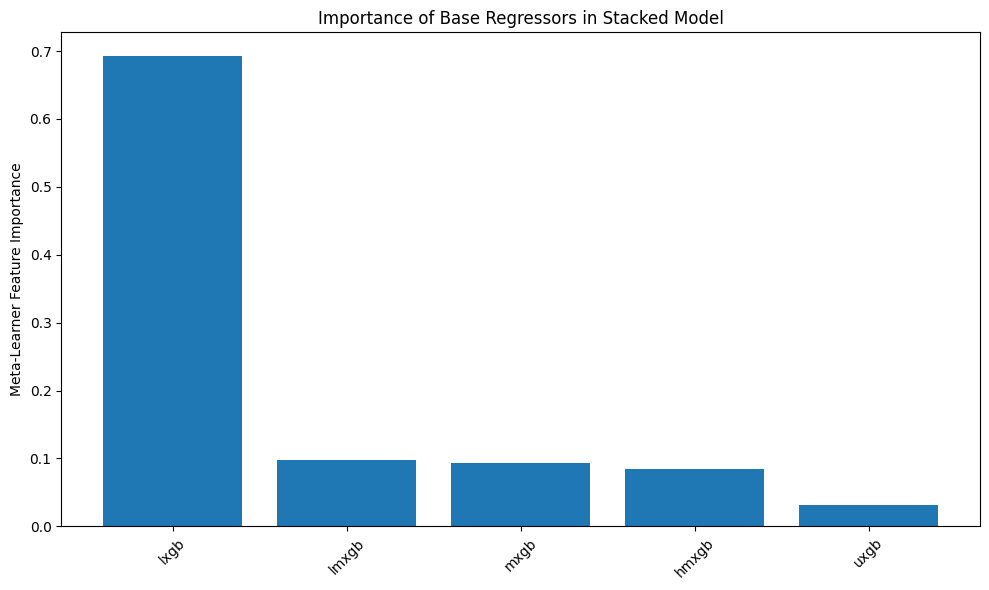

lxgb: 0.6930
lmxgb: 0.0982
mxgb: 0.0926
hmxgb: 0.0846
uxgb: 0.0316


In [11]:
   
""" Predict using the Entire Stack on validation """
# Generate Predictions from the base models
base_reg_preds = np.zeros((len(X_Val), len(estimators)))
for i, name in enumerate(fitted_base_models):
    base_reg_preds[:, i] = fitted_base_models[name].predict(X_Val)

# use the base regression values for the final regressor
y_pred_stack = final_regressor.predict(base_reg_preds)
mse_stack = mean_squared_error(y_Val, y_pred_stack)
print(f"Mean Squared Error (MSE): {mse_stack:.5f}")

""" Plot Importances """
base_names = [name for name, _ in estimators]
importances = final_regressor.feature_importances_

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(base_names, importances)
plt.ylabel("Meta-Learner Feature Importance")
plt.title("Importance of Base Regressors in Stacked Model")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

for name, imp in zip(base_names, importances):
    print(f"{name}: {imp:.4f}")

# Prediction on Test Data

In [12]:
df_test = pd.read_csv("regression-tabular-california-housing/test.csv", index_col=0, header=0)

df_test['RoomsPerPerson'] = df_test['AveRooms'] / df_test['AveOccup']
df_test['BedroomsPerRoom'] = df_test['AveBedrms'] / df_test['AveRooms']
bins = [0, 10, 30, np.inf]
labels = ['New', 'Mid-Age', 'Old']
df_test['AgeGroup'] = pd.cut(df_test['HouseAge'], bins=bins, labels=labels, right=False)
df_test = pd.get_dummies(df_test, columns=['AgeGroup'], drop_first=True)

# normalize Test data
for col in normalize_cols: 
    mu = normalize_params[col]["mu"]
    std = normalize_params[col]["std"]
    df_test[col] = (df_test[col] - mu)/std

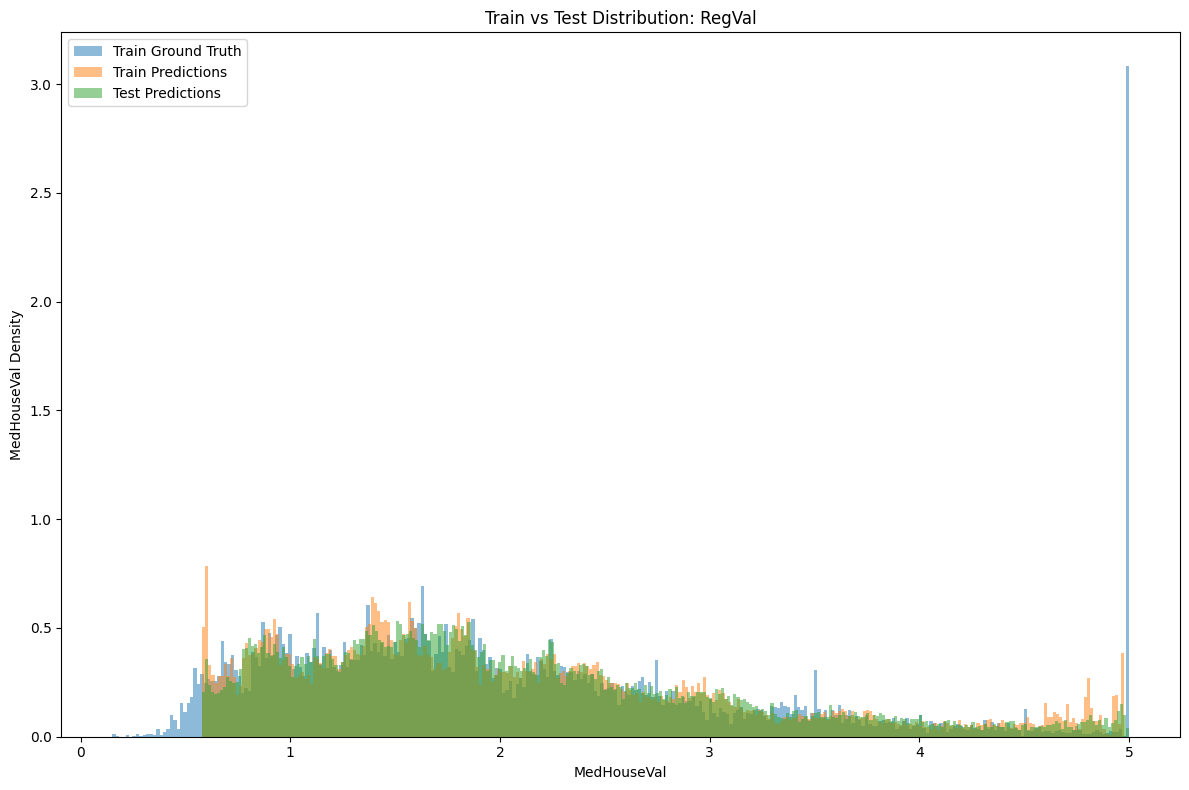

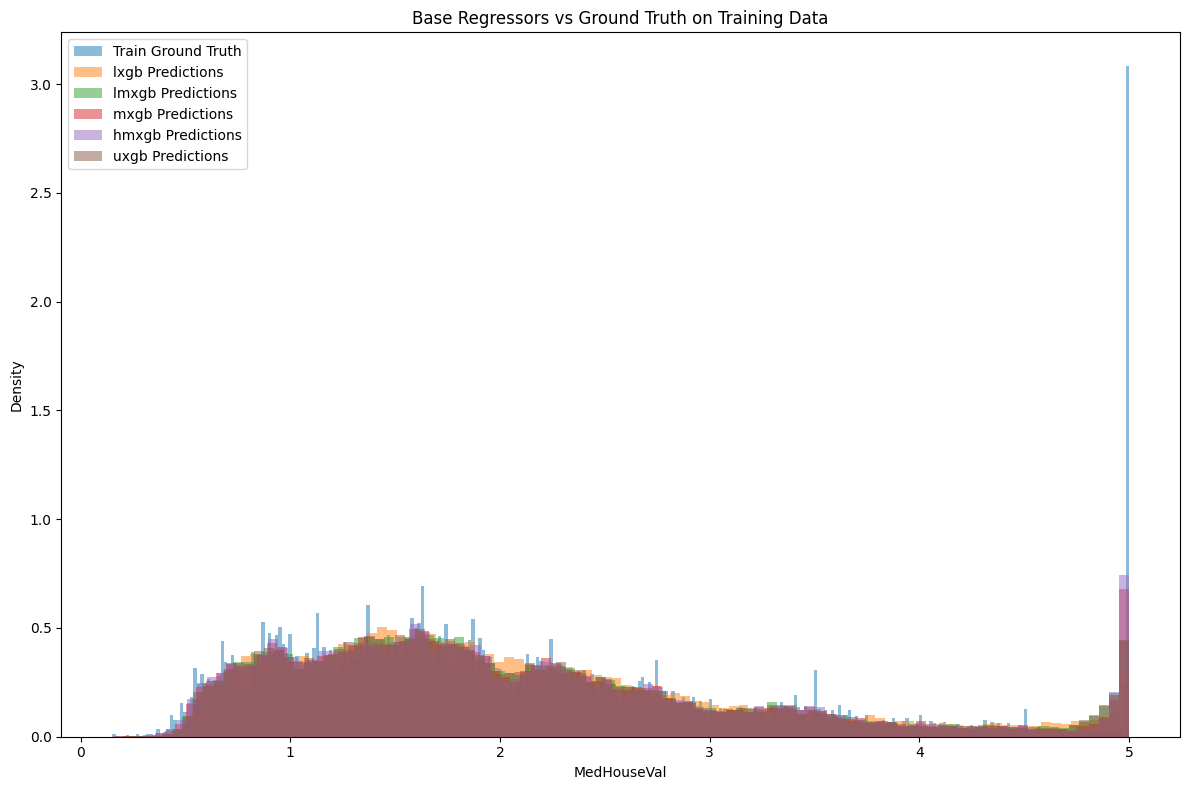

In [17]:
""" Histogram the train_ground_truth, train_pred, and test_pred for the overall model """
# Prediction on Train Set
train_base_preds = np.zeros((len(X_train), len(fitted_base_models)))
for i, name in enumerate(fitted_base_models):
    train_base_preds[:, i] = fitted_base_models[name].predict(X_train)
train_pred = final_regressor.predict(train_base_preds)

# Predictions are Clipped
train_pred = np.clip(train_pred, a_min=FLOOR, a_max=CAP)

# Prediction on test set
test_base_preds = np.zeros((len(df_test), len(fitted_base_models)))
for i, name in enumerate(fitted_base_models):
    test_base_preds[:, i] = fitted_base_models[name].predict(df_test)
test_pred = final_regressor.predict(test_base_preds)

# Predictions are Clipped
test_pred = np.clip(test_pred, a_min=FLOOR, a_max=CAP)

bins = 300
plt.figure(figsize=(12, 8))
plt.hist(y_train, bins=bins, alpha=0.5, label="Train Ground Truth", density=True)
plt.hist(train_pred, bins=bins, alpha=0.5, label="Train Predictions", density=True)
plt.hist(test_pred, bins=bins, alpha=0.5, label="Test Predictions", density=True)
plt.title(f"Train vs Test Distribution: RegVal")
plt.xlabel("MedHouseVal")
plt.ylabel(f"MedHouseVal Density")
plt.legend()
plt.tight_layout()


""" Histogram of base regressors vs ground truth """
plt.figure(figsize=(12, 8))

# ground truth
plt.hist(y_train, bins=bins, alpha=0.5, label="Train Ground Truth", density=True)

# loop over base estimators
for name, model in estimators:
    y_pred = model.fit(X_train, y_train).predict(X_train)   # fit on full training data
    y_pred = np.clip(y_pred, FLOOR, CAP)                   # apply clipping
    plt.hist(y_pred, bins=100, alpha=0.5, label=f"{name} Predictions", density=True)

plt.title("Base Regressors vs Ground Truth on Training Data")
plt.xlabel("MedHouseVal")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# Residuals Plot

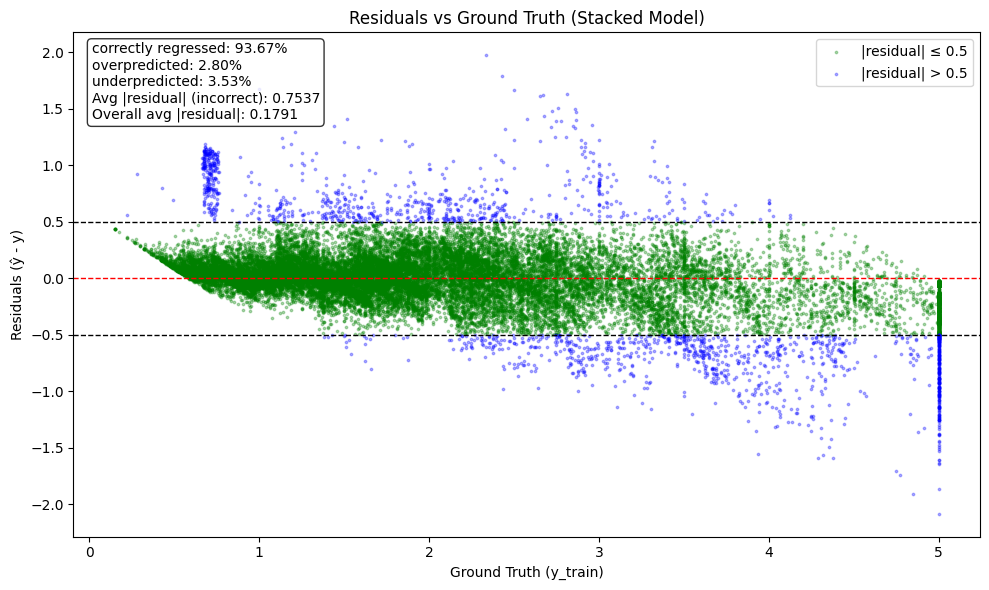

In [14]:
epsilon = 0.5

residuals = train_pred - y_train

plt.figure(figsize=(10, 6))

# mask for points within ±epsilon
within_mask = np.abs(residuals) <= epsilon
outside_mask = ~within_mask

# plot within-band points in green
plt.scatter(y_train[within_mask], residuals[within_mask], 
            alpha=0.3, s=3, c="green", label=f"|residual| ≤ {epsilon}")

# plot outside-band points in blue
plt.scatter(y_train[outside_mask], residuals[outside_mask], 
            alpha=0.3, s=3, c="blue", label=f"|residual| > {epsilon}")

# horizontal reference lines
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.axhline(epsilon, color="black", linestyle="--", linewidth=1)
plt.axhline(-epsilon, color="black", linestyle="--", linewidth=1)

plt.xlabel("Ground Truth (y_train)")
plt.ylabel("Residuals (ŷ - y)")
plt.title("Residuals vs Ground Truth (Stacked Model)")
plt.legend()

# ---- stats ----
pct_correct = 100 * np.mean(within_mask)
pct_over = 100 * np.mean(residuals > epsilon)
pct_under = 100 * np.mean(residuals < -epsilon)
avg_abs_resid_incorrect = np.mean(np.abs(residuals[outside_mask])) if np.any(outside_mask) else 0.0
overall_abs_resid = np.mean(np.abs(residuals))

# stats text
stats_text = (
    f"correctly regressed: {pct_correct:.2f}%\n"
    f"overpredicted: {pct_over:.2f}%\n"
    f"underpredicted: {pct_under:.2f}%\n"
    f"Avg |residual| (incorrect): {avg_abs_resid_incorrect:.4f}\n"
    f"Overall avg |residual|: {overall_abs_resid:.4f}"
)

# add textbox to plot
plt.gca().text(
    0.02, 0.98, stats_text,
    transform=plt.gca().transAxes,
    fontsize=10,
    verticalalignment='top',
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
)

plt.tight_layout()
plt.show()

# Submission File

In [15]:
"""Creating the submission file"""
submission = pd.DataFrame({ "id": df_test.index, "MedHouseVal": test_pred })
submission.to_csv("submission.csv", index=False)
